# Bodyfat Dataset

## Enunciado
### Trabalho Computacional 1
O conjunto de dados bodyfat do repositório Statlib fornece estimativas da porcentagem de gordura
corporal determinada a partir de pesagem debaixo d'água e várias medidas da circunferência de
várias partes do corpo de 252 homens. É interessante desenvolver uma equação para estimar a
gordura corporal em função da medida da circunferência abdominal (vide a descrição do conjunto
de dados e o contexto biológico em http://lib.stat.cmu.edu/datasets/bodyfat).
A variável de saída é a porcentagem de gordura corporal estimada a partir da equação de Siri (%), e
as variáveis preditoras de interesse são idade (anos), peso (libras), altura (polegadas) e
circunferências (todas em cm) do pescoço, abdômen, cintura, coxa, joelho, calcanhar, bíceps,
antebraço e punho.

* Usar os dados para determinar um bom modelo para estimar a porcentagem de gordura corporal a partir das outras variáveis (exceto densidade corporal – body density).
* Avaliar as suposições do modelo a partir de uma análise cuidadosa dos resíduos. Avaliar se qualquer uma das observações deve ser eliminada da análise (i.e. se há outliers e se estes devem ser eliminados do conjunto de dados usado para construir o modelo).
* Executar uma análise de sensibilidade do modelo a fim de determinar quais das variáveis preditoras são mais relevantes (tem mais importância) na estimação da gordura corporal.

### Trabalho Computacional 2
Aplicar os modelos neurais ADALINE e MLP ao problema de regressão linear múltipla
(Questão 2) do TC1 e comparar os resultados com aqueles obtidos com o modelo MQL. Use o erro
quadrático médio (MSE) como figura de mérito para comparação entre os vários modelos. Mostre
os histogramas dos resíduos de cada modelo. Use o teste de hipótese de KolmogorovSmirnov
(kstest2, no Matlab) para avaliar quão diferentes são os desempenhos dos modelos do ponto de
vista estatístico.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor, SquaredLoss
from scipy.stats import ks_2samp

## Carregando os dados
Carregamos os dados em um dataframe *df* e atribuimos as colunas com os valores referentes a cada caracteristica.

In [2]:
df=pd.read_csv('Bodyfat_statlib.dat',header=None,skiprows=0,delim_whitespace=True)
df.columns=['Density','SirisPct','Age','Weight','Height','NeckCirc','ChestCirc'
            ,'AbdomenCirc','HipCirc','ThighCirc','KneeCirc','AnkleCirc','BicepsCirc','ForearmCirc','WristCirc']
print(df.head())

   Density  SirisPct  Age  Weight  Height  NeckCirc  ChestCirc  AbdomenCirc  \
0   1.0708      12.3   23  154.25   67.75      36.2       93.1         85.2   
1   1.0853       6.1   22  173.25   72.25      38.5       93.6         83.0   
2   1.0414      25.3   22  154.00   66.25      34.0       95.8         87.9   
3   1.0751      10.4   26  184.75   72.25      37.4      101.8         86.4   
4   1.0340      28.7   24  184.25   71.25      34.4       97.3        100.0   

   HipCirc  ThighCirc  KneeCirc  AnkleCirc  BicepsCirc  ForearmCirc  WristCirc  
0     94.5       59.0      37.3       21.9        32.0         27.4       17.1  
1     98.7       58.7      37.3       23.4        30.5         28.9       18.2  
2     99.2       59.6      38.9       24.0        28.8         25.2       16.6  
3    101.2       60.1      37.3       22.8        32.4         29.4       18.2  
4    101.9       63.2      42.2       24.0        32.2         27.7       17.7  


Dividimos os dados agora em dados de entrada e saída, dfX e dfY através da função *truncate()* e retirando a coluna *SirisPct* de *df*

In [3]:
dfX=df.truncate(before='Age',axis='columns')
dfY=df.SirisPct

## Visualização da distribuição
Queremos agora visualizar a distribuição de valores das características, o melhor modo de fazer esta visualização é através do boxplot de todas as características para averiguar se existem outliers. 

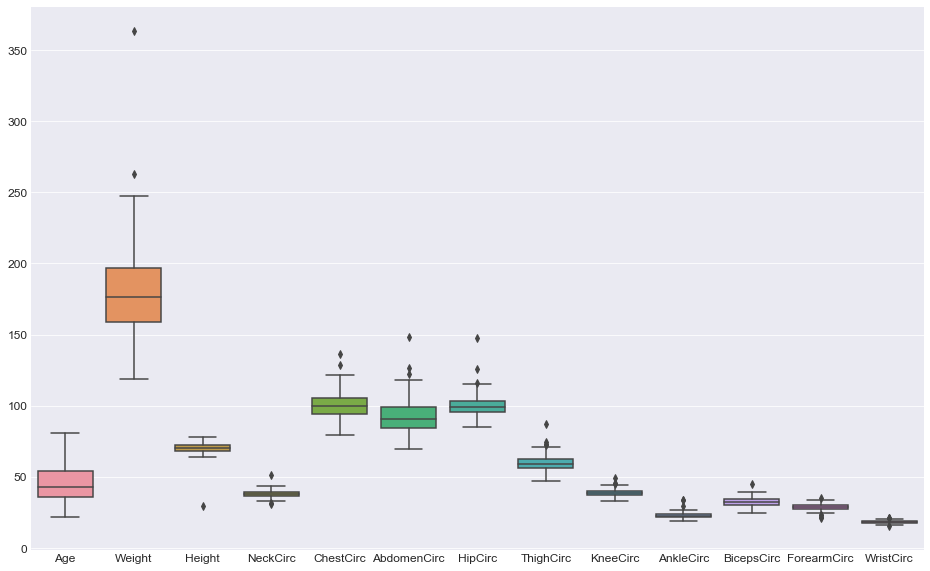

In [4]:
plt.rc('font',size=12)
sns.set_style(style='darkgrid')
plt.figure(figsize=[16,10])
sns.boxplot(data=dfX)
plt.show()

É possivel notar que existe um outlier claro quando olhamos para a característica Weight, por volta de 360 pounds, aproximadamente 150kg, este outlier é visto também em outras características, como AbdomenCirc, circunferência do abdomen. 

Mas este outlier não é resultado de um erro de medição, mas sim de medições em uma pessoa com obesidade, provavelmente, de modo que não existe razão para retira-la do modelo, pois caso a retirassemos estariamos reduzindo o nosso modelo para somente casos na média que não é o objetivo.

## Modelagem

Criamos o nosso modelo através da função *lstsq* que criará um modelo de regressão baseado nos mínimos quadrados.

In [5]:
W,residSumSq,Xrank,Xsvd=np.linalg.lstsq(dfX,dfY)
print(residSumSq)

[ 4431.82175163]


Podemos visualizar os pesos:

In [6]:
print(W)

[ 0.06346361 -0.03806879 -0.12870678 -0.54347276 -0.06843427  0.95490619
 -0.29986691  0.22469069 -0.04354751  0.13241799  0.16951551  0.43486663
 -1.722037  ]


Avaliando os residuos fazendo resid = W*X - Y

In [7]:
Xarray=np.array(dfX)
resid=np.dot(Xarray,W)-np.array(dfY)

E visualizando a distribuição dos resíduos em um histograma e um boxplot:

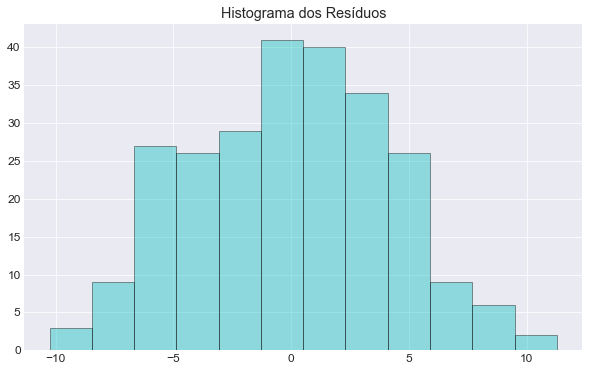

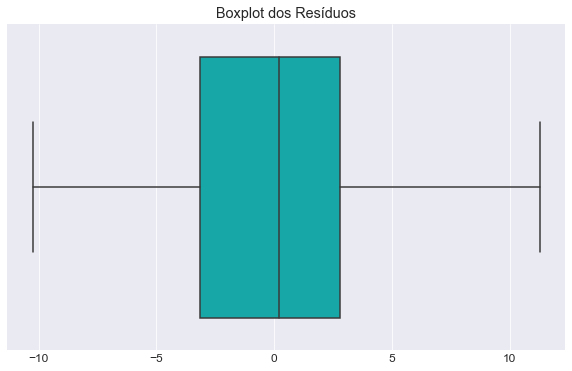

In [8]:
plt.figure(figsize=[10,6])
plt.rc('font',size=12)
sns.distplot(resid,kde=False,hist_kws={'edgecolor':'k'},color='c')
plt.title('Histograma dos Resíduos')
plt.show()
plt.figure(figsize=[10,6])
plt.rc('font',size=12)
sns.boxplot(resid,color='c')
plt.title('Boxplot dos Resíduos')
plt.show()

## Normalizado

Todo o processo é refeito normalizando os valores das características para entre 0 e 1 com 0 sendo o mínimo e o 1 sendo o máximo (MinMaxScaler)

In [9]:
dfScl=pd.DataFrame(MinMaxScaler().fit_transform(dfX),columns=dfX.columns)
print(dfScl.head())

        Age    Weight    Height  NeckCirc  ChestCirc  AbdomenCirc   HipCirc  \
0  0.016949  0.146127  0.792746  0.253731   0.242531     0.200762  0.151515   
1  0.000000  0.223789  0.886010  0.368159   0.251318     0.172808  0.218501   
2  0.000000  0.145105  0.761658  0.144279   0.289982     0.235070  0.226475   
3  0.067797  0.270795  0.886010  0.313433   0.395431     0.216010  0.258373   
4  0.033898  0.268751  0.865285  0.164179   0.316344     0.388818  0.269537   

   ThighCirc  KneeCirc  AnkleCirc  BicepsCirc  ForearmCirc  WristCirc  
0   0.294264  0.267081   0.189189    0.356436     0.460432   0.232143  
1   0.286783  0.267081   0.290541    0.282178     0.568345   0.428571  
2   0.309227  0.366460   0.331081    0.198020     0.302158   0.142857  
3   0.321696  0.267081   0.250000    0.376238     0.604317   0.428571  
4   0.399002  0.571429   0.331081    0.366337     0.482014   0.339286  


In [10]:
W,residSum,Xrank,Xsvd=np.linalg.lstsq(dfScl,dfY)
print(residSum)
resid=np.dot(dfScl,W)-dfY #residuos

[ 4448.33248812]


Podemos visualizar os pesos e avaliar sua influência criando uma tabela com os pesos referentes a cada característica:

In [11]:
cols=dfScl.columns
print(pd.DataFrame(data={'Pesos':W},index=cols))

                 Pesos
Age           4.344589
Weight      -31.631390
Height        2.784829
NeckCirc     -8.846775
ChestCirc     0.826516
AbdomenCirc  75.632082
HipCirc      -9.188786
ThighCirc    11.717941
KneeCirc     -0.130024
AnkleCirc     3.312236
BicepsCirc    3.798248
ForearmCirc   7.044701
WristCirc    -9.557864


Podemos notar que as características que possuem a maior influencia no nosso modelo são o Peso e a medida da Circunferência do abdomen. 

Em seguida podemos visualizar a distribuição dos resíduos do nosso modelo:

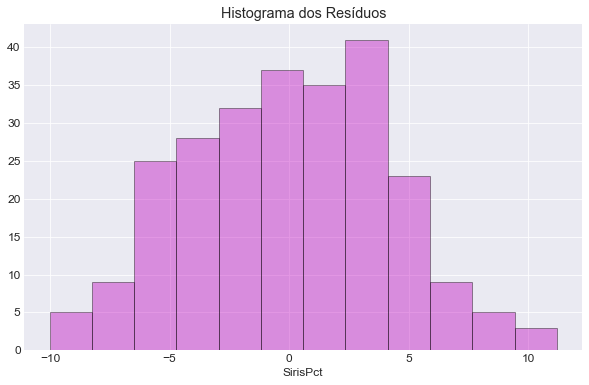

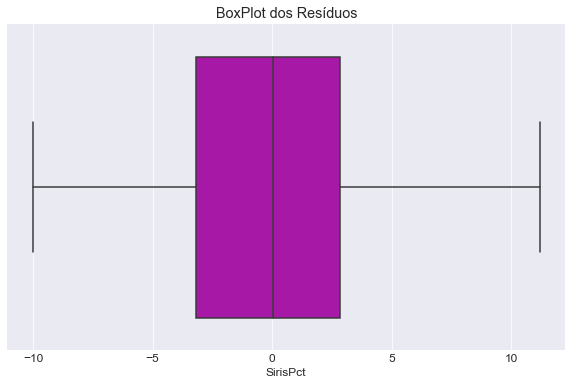

In [12]:
plt.figure(figsize=[10,6])
plt.rc('font',size=12)
sns.distplot(resid,kde=False,hist_kws={'edgecolor':'k'},color='m')
plt.title('Histograma dos Resíduos')
plt.show()
plt.figure(figsize=[10,6])
plt.rc('font',size=12)
sns.boxplot(resid,color='m')
plt.title('BoxPlot dos Resíduos')
plt.show()

## Comparando com Redes Neurais

Primeiro criamos as redes neurais, podemos criar uma rede ADALINE a partir da função de SGD, já que o ADALINE nada mais é do que um SGD de regressão com alguns parametros como a função custo sendo o erro quadrático.

Já na MLP foram testados várias combinações de parametros, a melhor combinação foi com a função de ativação sendo a sigmoide logistica e a função de treinamento sendo "lbfgs", Limited-memory BFGS, método pertencente aos métodos de Quasi-Newton. Para as camadas ocultas foi visto como melhor solução uma única camada com 20 neurônios.

Já o método da regressão foi utilizada somente a função para multiplicar a entrada pelos pesos obtidos na modelagem normalizada

In [13]:
layersize=[20,]
mlp=MLPRegressor(hidden_layer_sizes=layersize,activation='logistic',solver='lbfgs',learning_rate_init=0.01,max_iter=500,tol=1e-4)
mlp.fit(X=dfScl,y=dfY)
sgd=SGDRegressor(loss='squared_loss',penalty='none',max_iter=500,tol=1e-4,eta0=0.2)
sgd.fit(X=dfScl,y=dfY)
#Saidas
mlpOut=mlp.predict(dfScl)
sgdOut=sgd.predict(dfScl)
mqlOut=np.dot(dfScl,W)
print('MSE MLP: ' + str(mean_squared_error(y_pred=mlpOut,y_true=dfY)))
print('MSE MQL: ' + str(mean_squared_error(y_pred=mqlOut,y_true=dfY)))
print('MSE ADALINE: ' +str(mean_squared_error(y_pred=sgdOut,y_true=dfY)))

MSE MLP: 5.31573461925
MSE MQL: 17.6521130481
MSE ADALINE: 25.7449752541


MLP demonstrou um desempenho bem superior aos outros dois métodos, que por sua vez demonstraram desempenho similar (Adaline e MQL).

Analisando a distribuição dos resíduos de cada modelo:

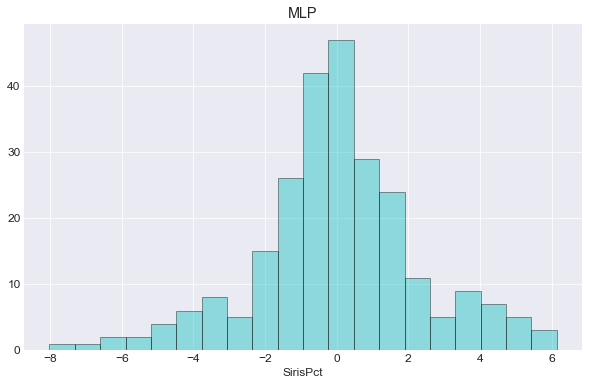

In [14]:
plt.figure(figsize=[10,6])
plt.rc('font',size=12)
sns.distplot(mlpOut-dfY,kde=False,hist_kws={'edgecolor':'k'},color='c')
plt.title('MLP')
plt.show()

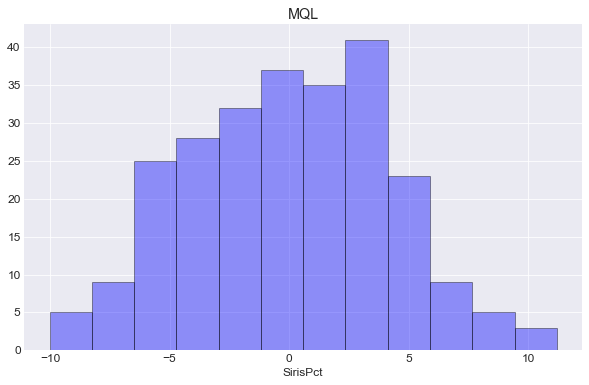

In [15]:
plt.figure(figsize=[10,6])
plt.rc('font',size=12)
sns.distplot(mqlOut-dfY,kde=False,hist_kws={'edgecolor':'k'},color='b')
plt.title('MQL')
plt.show()

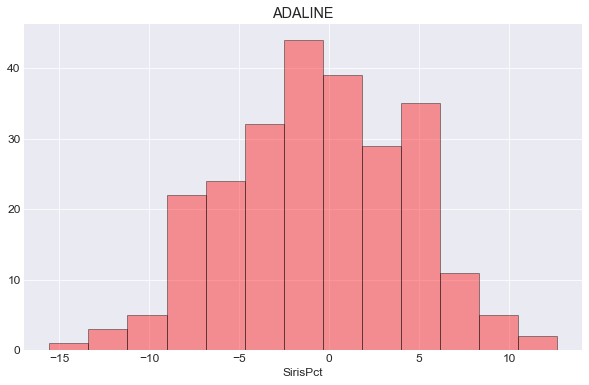

In [16]:
plt.figure(figsize=[10,6])
plt.rc('font',size=12)
sns.distplot(sgdOut-dfY,kde=False,hist_kws={'edgecolor':'k'},color='r')
plt.title('ADALINE')
plt.show()

Ao final fazemos o teste de Kolmogorov-Smirnov para comparar os resíduos dos modelos:

In [17]:
print('MLP com MQL: '+str(ks_2samp(mlpOut-dfY,mqlOut-dfY)))
print('MLP com Adaline: '+str(ks_2samp(mlpOut-dfY,sgdOut-dfY)))
print('Adaline com MQL: '+str(ks_2samp(mqlOut-dfY,sgdOut-dfY)))

MLP com MQL: Ks_2sampResult(statistic=0.2142857142857143, pvalue=1.4412130918936653e-05)
MLP com Adaline: Ks_2sampResult(statistic=0.2857142857142857, pvalue=1.4426471900228524e-09)
Adaline com MQL: Ks_2sampResult(statistic=0.099206349206349215, pvalue=0.15799443325377235)
